## Breast Cancer (Wisconsin dataset) Exploratory data analysis.
The goal is to identify tends, anomalies and get insights from the BreastCancer dataset in order to properly construct models and get conclusions about the dataset described in BreastCancerPreprocessing notebook in this same folder

<image src="https://miro.medium.com/max/828/1*pxFCmhRFTighUn88baLcSA.png
" alt="Malignant and benign cells from a digitized image of a fine needle aspirate">


In [331]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import time

In [332]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

## Reading dataset

In [333]:
df=pd.read_parquet('../data/interim/Breastclean1.parquet')

# We'll use pandas profiling in order to get a first overview of the data and check it's structure

In [334]:
"""from pandas_profiling import ProfileReport
profile = ProfileReport(df, title=" Profiling Report 1",
                        explorative=True, samples=None, correlations=None, 
                        missing_diagrams=None, duplicates=None, interactions=None)
profile.to_notebook_iframe()"""

'from pandas_profiling import ProfileReport\nprofile = ProfileReport(df, title=" Profiling Report 1",\n                        explorative=True, samples=None, correlations=None, \n                        missing_diagrams=None, duplicates=None, interactions=None)\nprofile.to_notebook_iframe()'

## First data profiling insights
Checking the data profiling, we can see almost all columns contain spread values wich makes no sense in the context we are in, since we are talking about cells, hence we'll apply outlier detection using IQR  in order to check whether the data distribution changes or not, and replacing outliers using np.where function for na

In [335]:
for i in df.columns:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1
        df[i]=np.where((df[i] < (Q1 - 1.5 * IQR)) |(df[i] > (Q3 + 1.5 * IQR)),np.nan,df[i])

## Second data profiling after applying  outlier detection:


In [336]:
""""# import pandas profilling lib
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title=" Profiling Report 1",
                        explorative=True, samples=None, correlations=None, 
                        missing_diagrams=None, duplicates=None, interactions=None)
profile.to_notebook_iframe()"""

'"# import pandas profilling lib\nfrom pandas_profiling import ProfileReport\nprofile = ProfileReport(df, title=" Profiling Report 1",\n                        explorative=True, samples=None, correlations=None, \n                        missing_diagrams=None, duplicates=None, interactions=None)\nprofile.to_notebook_iframe()'

After applying outlier detection with the interquartile range, profiling shows that many of the columns are already in ranges that make sense with respect to the context of the analysis, however some columns like perimeter_se and textura_se still contain extraneous values that are out of the range we are interested in .we must try to correct  or review what happens with these columns in order to  continue with the analysis since these will generate problems when applying the classification model.


In [337]:
df.to_parquet("../data/interim/Breastnooutliers.parquet", index = False) ##saving dataset with outliers replaced by na in order to make an experiment.

## Checking perimeter se column and texture_se column

In [338]:
df['perimeter_se'].describe() ## as we can se, perimeter_ se contains values in a strange range that makes no sense, we need to fix this issue later in this notebook.

count     534.000000
mean     2234.200428
std      1258.611038
min         0.771400
25%      1467.250000
50%      2076.500000
75%      2924.250000
max      5632.000000
Name: perimeter_se, dtype: float64

In [339]:
df['texture_se'].describe() ## ## as we can se, texture_ se  also contains values in a strange range that makes no sense, we need to fix this issue later in this notebook as well.


count     565.000000
mean      803.022847
std       790.243308
min         0.360200
25%         0.856100
50%      1023.000000
75%      1398.000000
max      2927.000000
Name: texture_se, dtype: float64

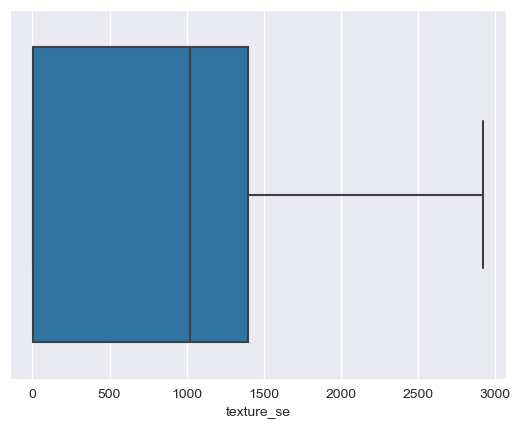

In [340]:
sns.boxplot(x=df["texture_se"])
plt.show()

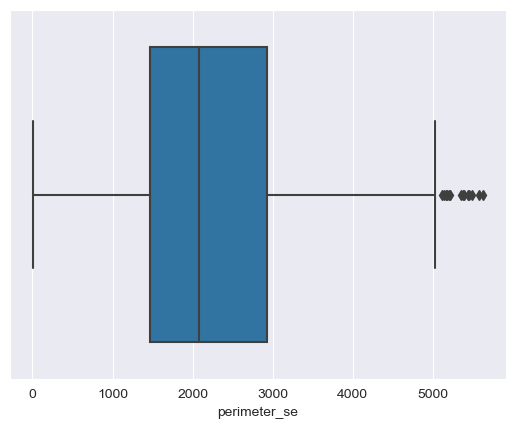

In [341]:
sns.boxplot(x=df["perimeter_se"])
plt.show()

## Issues in the columns mentioned above will be fixed later in the notebook, for now, lets start with exploratory data analysis over the rest of the columns wich are properly distributed in ranges that make sense for our analysis.

## <center>Exploratory data analysis</center>



In [342]:
df.head()


,perimeter_se,radius_worst,concave points_mean,smoothness_mean,area_mean,concavity_se,texture_mean,concavity_worst,smoothness_se,concave points_se,...,concavity_mean,symmetry_mean,symmetry_worst,diagnosis,fractal_dimension_se,perimeter_mean,compactness_worst,symmetry_se,compactness_se,radius_se
0,2225.0,13.28,0.01162,0.07561,421.0,0.005949,17.07,0.03046,0.006583,0.006296,...,0.008306,0.1671,0.2731,0.0,0.002668,73.70,0.06476,0.02216,0.006991,0.3534
1,2362.0,17.52,0.09429,0.10480,716.9,0.073590,NaN,NaN,0.004625,0.016080,...,NaN,0.2128,0.4089,1.0,0.006142,103.40,NaN,0.02137,0.048440,0.2602
2,2346.0,14.19,0.02548,0.08794,504.1,0.031370,13.37,0.17690,0.006494,0.010690,...,0.040520,0.1601,0.2564,0.0,0.004392,82.29,0.22080,0.01731,0.027680,0.3265
3,1429.0,10.75,0.02292,0.08481,280.5,0.050280,16.84,0.43410,0.005954,0.008510,...,0.084220,0.2036,0.2982,0.0,0.004031,61.64,0.34160,0.01750,0.034710,0.1844
4,2406.0,15.49,0.09353,0.12730,519.8,0.035530,21.82,NaN,0.005731,0.012260,...,0.185900,NaN,0.4378,1.0,0.003749,87.50,0.54010,0.02143,0.035020,0.3063


## 1. Separating  2 dataframes - dataset x for features and  dataset y as target:


In [343]:
x = df.drop('diagnosis', axis = 1)
y = df.diagnosis

In [344]:
x.head()


,perimeter_se,radius_worst,concave points_mean,smoothness_mean,area_mean,concavity_se,texture_mean,concavity_worst,smoothness_se,concave points_se,...,smoothness_worst,concavity_mean,symmetry_mean,symmetry_worst,fractal_dimension_se,perimeter_mean,compactness_worst,symmetry_se,compactness_se,radius_se
0,2225.0,13.28,0.01162,0.07561,421.0,0.005949,17.07,0.03046,0.006583,0.006296,...,0.09958,0.008306,0.1671,0.2731,0.002668,73.70,0.06476,0.02216,0.006991,0.3534
1,2362.0,17.52,0.09429,0.10480,716.9,0.073590,NaN,NaN,0.004625,0.016080,...,0.14170,NaN,0.2128,0.4089,0.006142,103.40,NaN,0.02137,0.048440,0.2602
2,2346.0,14.19,0.02548,0.08794,504.1,0.031370,13.37,0.17690,0.006494,0.010690,...,0.11940,0.040520,0.1601,0.2564,0.004392,82.29,0.22080,0.01731,0.027680,0.3265
3,1429.0,10.75,0.02292,0.08481,280.5,0.050280,16.84,0.43410,0.005954,0.008510,...,0.12330,0.084220,0.2036,0.2982,0.004031,61.64,0.34160,0.01750,0.034710,0.1844
4,2406.0,15.49,0.09353,0.12730,519.8,0.035530,21.82,NaN,0.005731,0.012260,...,0.17030,0.185900,NaN,0.4378,0.003749,87.50,0.54010,0.02143,0.035020,0.3063


In [345]:
y.head()

0    0.0
1    1.0
2    0.0
3    0.0
4    1.0
Name: diagnosis, dtype: float64

## 2. Target distribution:
Let's plot the distribution of diagnosis variable in order to check whether its unbalanced or balanced, remember that since we applied label encoder in the preprocessing notebook,  **0 represents benignant and 1 represents malignant**


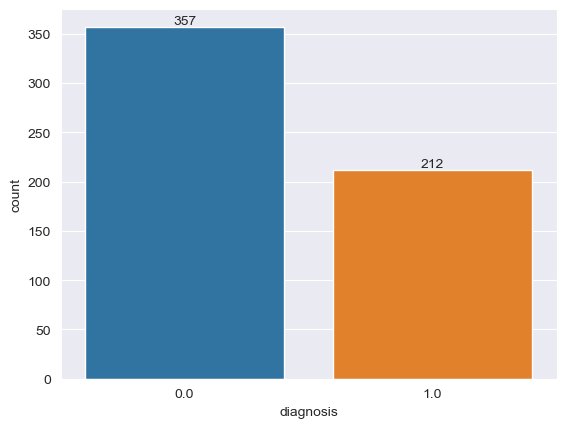

In [346]:
ax = sns.countplot(x=df['diagnosis'],
                   order=df['diagnosis'].value_counts(ascending=False).index);

abs_values = df['diagnosis'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.show()

**Based on the countplot we can see there are 212 rows classified as malignant and 357 classified as benign wich means there is no important imbalance present across the target variable.**

In [347]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
perimeter_se,534.0,2234.200428,1258.611038,0.771400,1467.250000,2076.500000,2924.250000,5632.00000
radius_worst,541.0,16.208854,4.300495,7.930000,13.110000,14.990000,18.550000,29.17000
concave points_mean,548.0,0.046349,0.035261,0.000000,0.019688,0.032635,0.068505,0.16040
smoothness_mean,541.0,0.095475,0.013079,0.062510,0.085820,0.094910,0.104400,0.13350
area_mean,544.0,608.214890,273.550172,143.500000,412.675000,537.300000,717.550000,1326.00000
...,...,...,...,...,...,...,...,...
perimeter_mean,556.0,90.235576,21.646564,43.790000,74.832500,85.815000,102.625000,147.30000
compactness_worst,510.0,0.241222,0.135667,0.027290,0.139900,0.207100,0.325975,0.69970
symmetry_se,536.0,0.019246,0.005668,0.007882,0.014935,0.018435,0.022510,0.03546
compactness_se,538.0,0.022845,0.012908,0.002252,0.012648,0.019650,0.030758,0.06213


# 3. Checking na values percentage after replacing outliers for na

In [348]:
print((x.isnull().sum()/len(x)*100).sort_values())


texture_se            0.702988
texture_worst         0.878735
texture_mean          1.230228
perimeter_mean        2.284710
perimeter_worst       2.636204
                       ...    
symmetry_mean         9.841828
compactness_worst    10.369069
area_se              11.775044
radius_se            12.126538
symmetry_worst       12.653779
Length: 30, dtype: float64


In [349]:
x.info() ##all values are the datatype they are supposed to, also we can see there are null values. Later in the notebook we'll explore possible solutions to handle na values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   perimeter_se             534 non-null    float64
 1   radius_worst             541 non-null    float64
 2   concave points_mean      548 non-null    float64
 3   smoothness_mean          541 non-null    float64
 4   area_mean                544 non-null    float64
 5   concavity_se             543 non-null    float64
 6   texture_mean             562 non-null    float64
 7   concavity_worst          522 non-null    float64
 8   smoothness_se            539 non-null    float64
 9   concave points_se        548 non-null    float64
 10  area_worst               534 non-null    float64
 11  compactness_mean         535 non-null    float64
 12  radius_mean              523 non-null    float64
 13  area_se                  502 non-null    float64
 14  concave points_worst     5

Based on the analysis developed by Shubam Sumbria, it might be a good idea to extract Mean , Squared error and worst features and place them in different datasets in order to better analyse variables since there are 10 columns for each one of them.

https://medium.com/analytics-vidhya/breast-cancer-diagnostic-dataset-eda-fa0de80f15bd

In [350]:
df_mean = df[['diagnosis','concave points_mean',
       'smoothness_mean', 'area_mean',
        'texture_mean','compactness_mean',
        'radius_mean' ,'fractal_dimension_mean',
       'concavity_mean', 'symmetry_mean', 'perimeter_mean']]
df_se = df[['diagnosis','perimeter_se', 'concavity_se',
        'smoothness_se', 'concave points_se',
        'area_se', 'texture_se',
        'fractal_dimension_se','symmetry_se',
        'compactness_se', 'radius_se']]
df_worst = df[['diagnosis','radius_worst',
                'concavity_worst','area_worst',
                'fractal_dimension_worst', 'perimeter_worst',
                'texture_worst', 'smoothness_worst',
                'symmetry_worst', 'compactness_worst',
               'concave points_worst']]

In [351]:
print(len(df_mean.columns),len(df_se.columns),len(df_worst.columns))

11 11 11


# 4. Correlation of mean features with diagnosis :
The next graph shows correlation between each feature contained in df_mean dataset and our target variable diagnosis.

# **Notes:**

**Negatively correlated  features of df_mean with diagnosis**
* fractal_dimension_mean   -0.008215


**Most correlated variables of df_mean with diagnosis**
* radius_mean               0.727613
* area_mean                 0.735214
* concavity_mean            0.744735
* perimeter_mean            0.753094
* concave points_mean       0.787617

**Less correlated variables of df_mean with diagnosis**
* symmetry_mean             0.339929
* smoothness_mean           0.361728

fractal_dimension_mean   -0.008215
symmetry_mean             0.339929
smoothness_mean           0.361728
texture_mean              0.417757
compactness_mean          0.588415
radius_mean               0.727613
area_mean                 0.735214
concavity_mean            0.744735
perimeter_mean            0.753094
concave points_mean       0.787617
diagnosis                 1.000000
dtype: float64


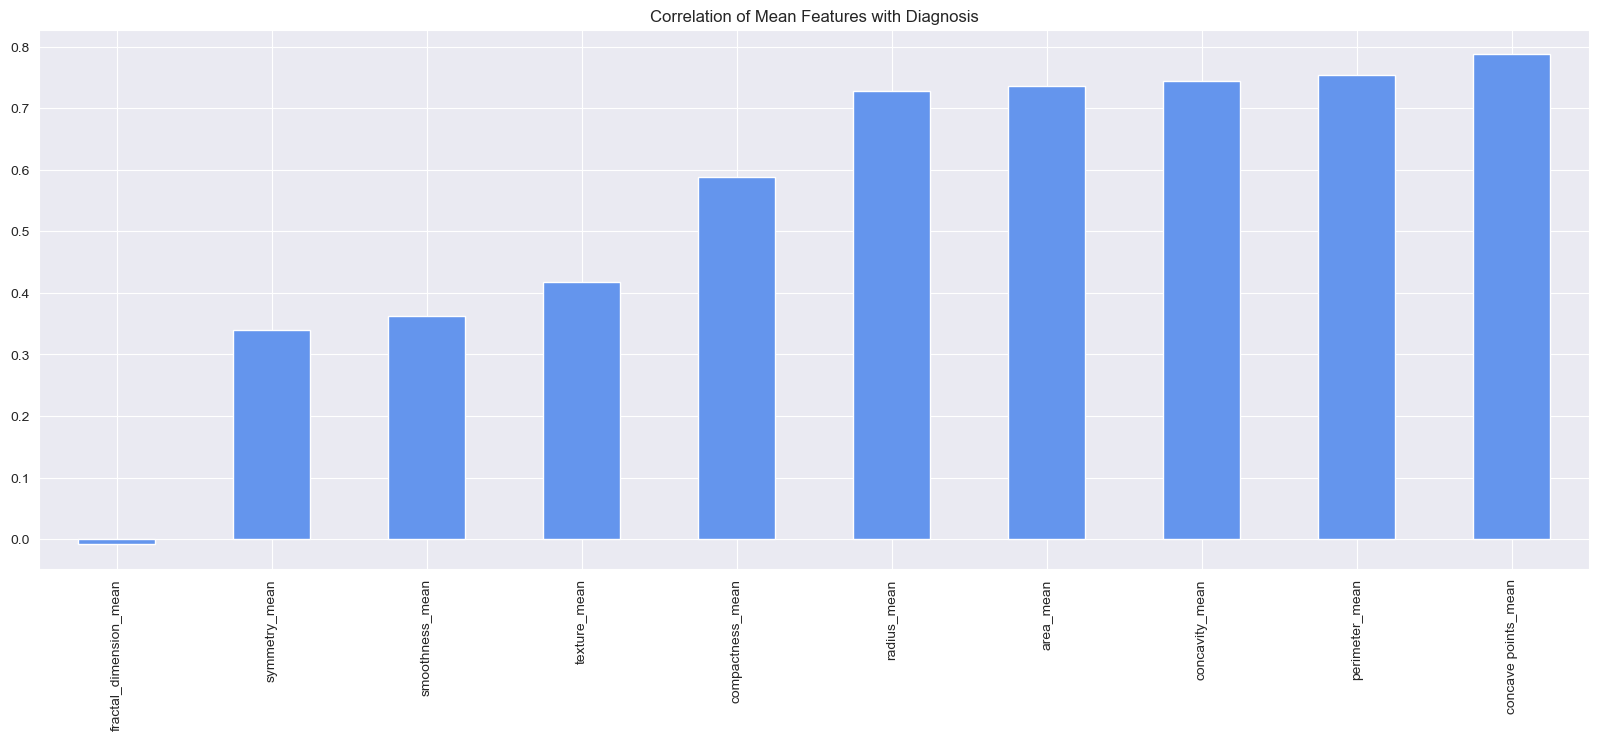

In [352]:
plt.figure(figsize=(20, 7))
df_mean.drop('diagnosis', axis=1).corrwith(df_mean.diagnosis).sort_values().plot(kind='bar', grid=True, title="Correlation of Mean Features with Diagnosis", color="cornflowerblue");
print(df_mean.corrwith(df_mean.diagnosis).sort_values())
plt.show()
##this code line was taken  and briefly modified from Shubam Sumbria's article  https://medium.com/analytics-vidhya/breast-cancer-diagnostic-dataset-eda-fa0de80f15bd


## 5. Correlation of se features with diagnosis :
The next graph shows correlation between each feature contained in df_se dataset and our target variable diagnosis:

# **Notes :**

**Negatively correlated  features of df_se  with diagnosis**
* symmetry_se            -0.151412
* smoothness_se          -0.015034
* texture_se             -0.012570


**Most correlated variables of df_se with diagnosis**
* radius_se               0.612715
* area_se                 0.677079

**Less correlated variables of df_se with diagnosis**
* compactness_se          0.377926
* fractal_dimension_se    0.193466



symmetry_se            -0.151412
smoothness_se          -0.015034
texture_se             -0.012570
fractal_dimension_se    0.193466
compactness_se          0.377926
concavity_se            0.449197
perimeter_se            0.459469
concave points_se       0.469367
radius_se               0.612715
area_se                 0.677079
diagnosis               1.000000
dtype: float64


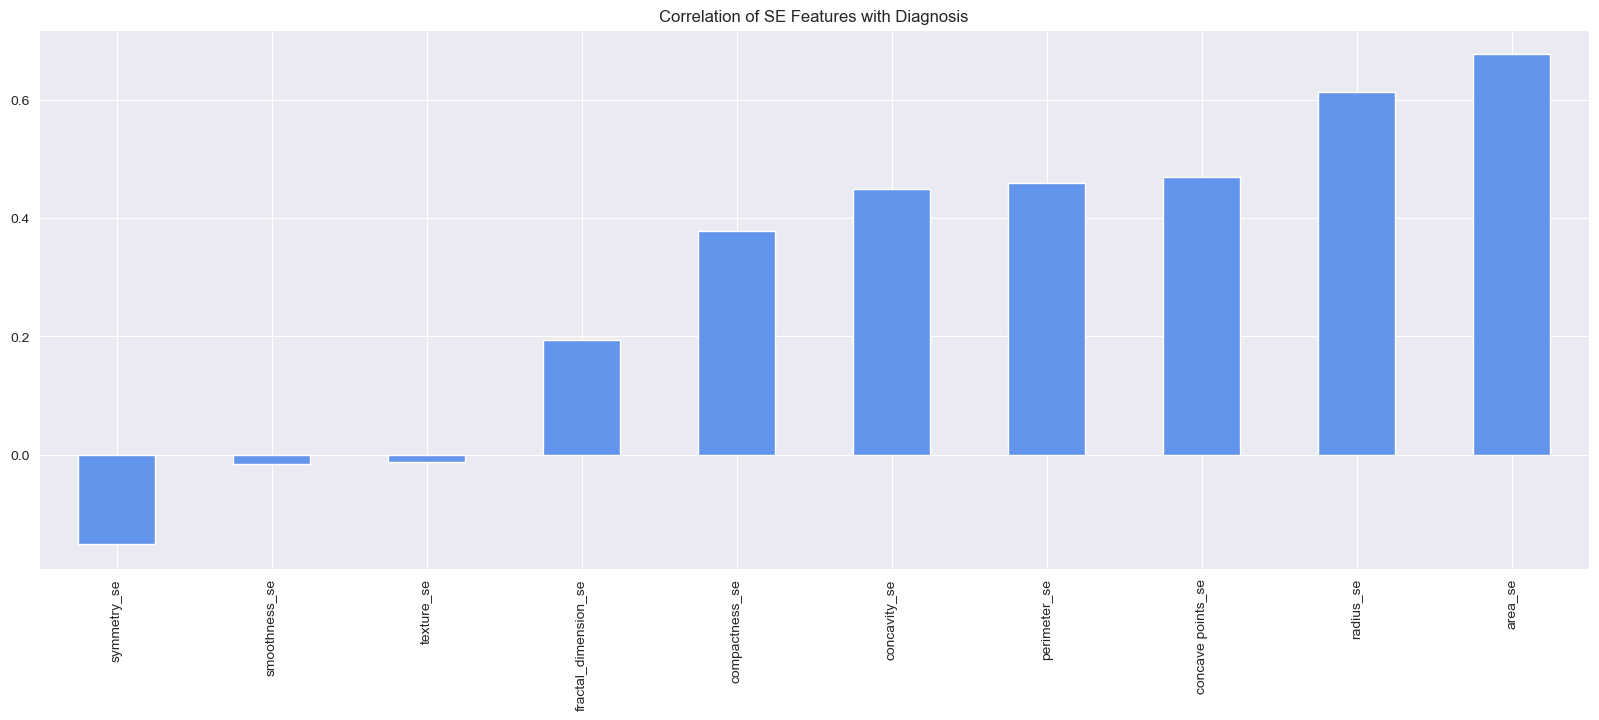

In [353]:
plt.figure(figsize=(20, 7))
df_se.drop('diagnosis', axis=1).corrwith(df_se.diagnosis).sort_values().plot(kind='bar', grid=True, title="Correlation of SE Features with Diagnosis", color="cornflowerblue");
print(df_se.corrwith(df_se.diagnosis).sort_values())
plt.show()
##this code line was taken  and briefly modified from Shubam Sumbria's article  https://medium.com/analytics-vidhya/breast-cancer-diagnostic-dataset-eda-fa0de80f15bd

## 6. Correlation of worst features with diagnosis :
The next graph shows correlation between each feature contained in df_worst dataset and our target variable diagnosis:

# **Notes :**

**Negatively correlated  features of df_worst  with diagnosis**
* None

**Most correlated variables of df_worst with diagnosis**
* area_worst                 0.784901
* radius_worst               0.790226
* concave points_worst       0.791755
* perimeter_worst            0.801134

**Less correlated variables of df_worst with diagnosis**
* fractal_dimension_worst    0.286903
* symmetry_worst             0.377631

fractal_dimension_worst    0.286903
symmetry_worst             0.377631
smoothness_worst           0.428098
texture_worst              0.444382
compactness_worst          0.590499
concavity_worst            0.689553
area_worst                 0.784901
radius_worst               0.790226
concave points_worst       0.791755
perimeter_worst            0.801134
diagnosis                  1.000000
dtype: float64


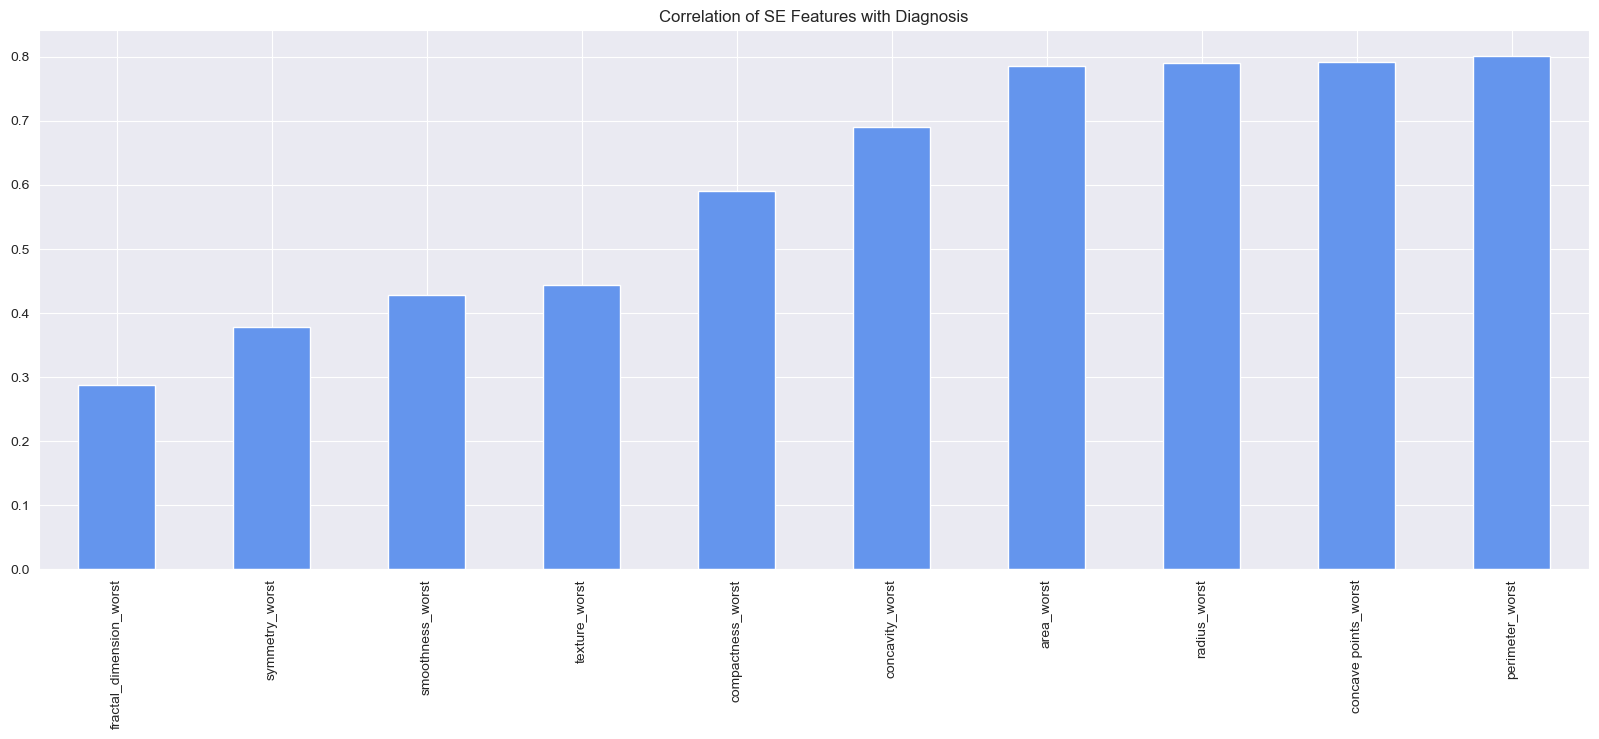

In [354]:
plt.figure(figsize=(20,7))
df_worst.drop('diagnosis', axis=1).corrwith(df_worst.diagnosis).sort_values().plot(kind='bar', grid=True, title="Correlation of SE Features with Diagnosis", color="cornflowerblue");
print(df_worst.corrwith(df_worst.diagnosis).sort_values())
plt.show()
##this code line was taken  and briefly modified from Shubam Sumbria's article  https://medium.com/analytics-vidhya/breast-cancer-diagnostic-dataset-eda-fa0de80f15bd

## 7. Correlation matrix of df_se features
As shown in the correlation heatmap, there are highly correlated features within df_se dataset, wee need to delete one of the highly correlated features because they're explaining the same information and might cause problems like autocorrelation, overfitting and over dimensionality especially in linear models.

**Highly correlated features :**
* perimeter_se - area_se ( corr= 0.8)
* perimeter_se - radius_se (corr =0.7)
* concavity_se  - concave points_se (corr= 0.7)
* concavity_se - compactness_se (corr=0.8)
* concave points_se- compactness_se (corr=0.7)
* area_se - radius_se (corr=0.9)
* fractal_dimension_se -compactness_se (corr=0.8)


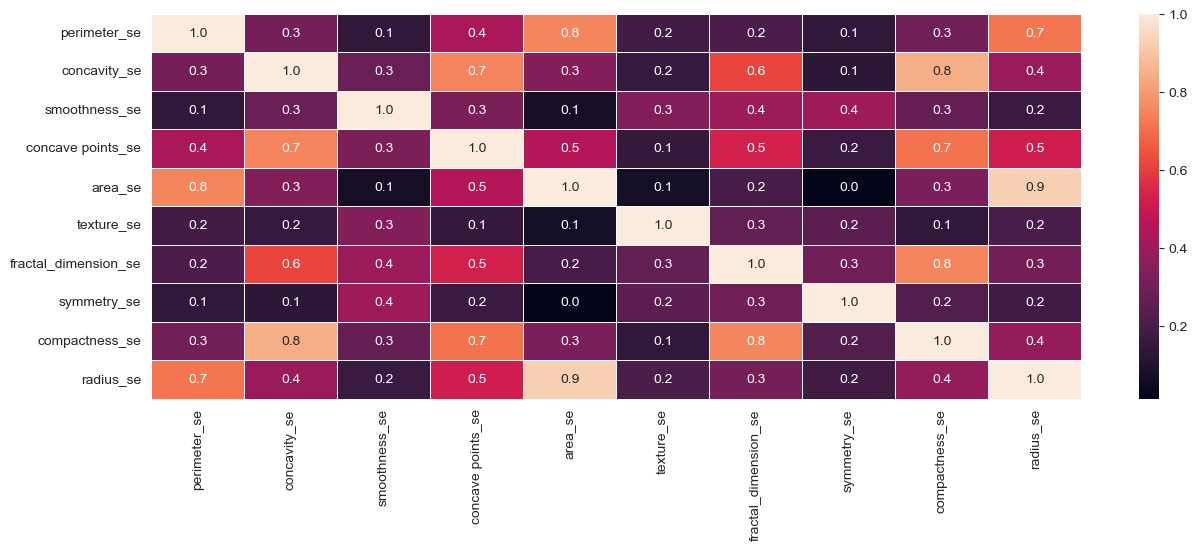

In [355]:
f, ax = plt.subplots(figsize = ( 15, 5))
sns.heatmap(df_se.drop('diagnosis',axis=1).corr(), annot = True, linewidth = 0.5, fmt = '.1f', ax = ax )
plt.show()

## 8. Correlation matrix of df_mean features
As shown in the correlation heatmap, there are highly correlated features within df_mean dataset, wee need to delete one of the highly correlated features because they're explaining the same information and might cause problems like autocorrelation, overfitting and over dimensionality especially in linear models.

**Highly correlated features :**
* concave_points_mean - area_mean ( corr= 0.8)
* concave_points_mean - compactness_mean ( corr= 0.8)
* concave_points_mean - radius_mean ( corr= 0.8)
* concave_points_mean - concavity_mean ( corr= 0.9)
* concave_points_mean - perimeter_mean ( corr= 0.8)
* area_mean - perimeter_mean (corr=1)
* area_mean - radius_mean (corr=1)
* compactness_mean - concavity_mean (corr=0.9)
* radius_mean - perimeter_mean (corr=1)
* radius_mean - concavity_mean (corr=0.7)
* concavity_mean -perimeter_mean (corr=0.7)

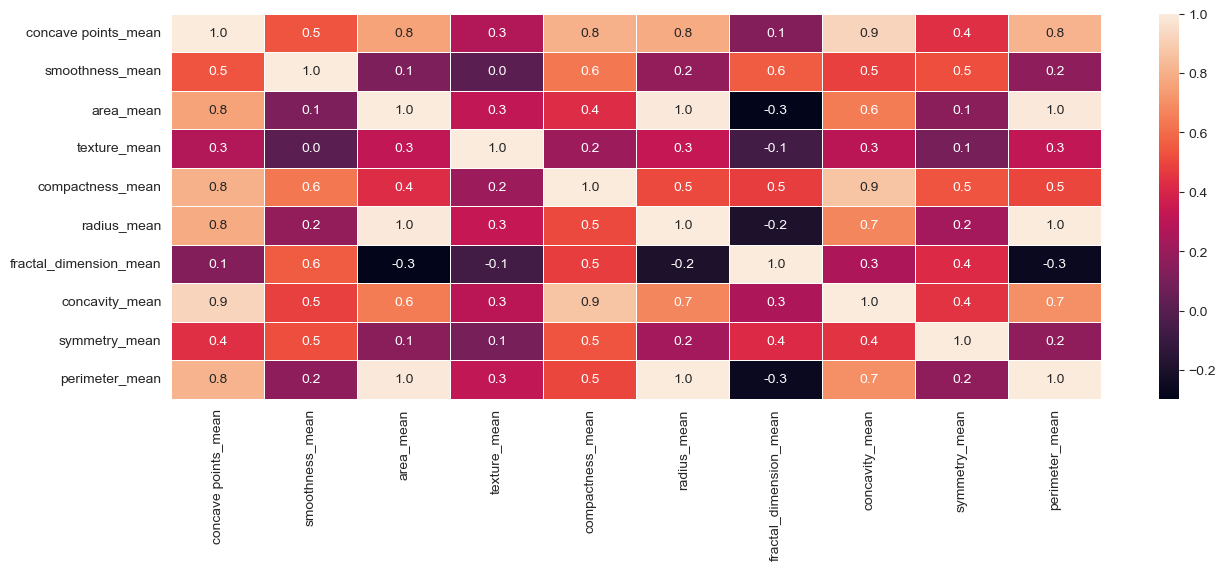

In [356]:
f, ax = plt.subplots(figsize = ( 15, 5))
sns.heatmap(df_mean.drop('diagnosis',axis=1).corr(), annot = True, linewidth = 0.5, fmt = '.1f', ax = ax )
plt.show()

## 9. Correlation matrix of df_worst features
As shown in the correlation heatmap, there are highly correlated features within df_worst dataset, wee need to delete one of the highly correlated features because they're explaining the same information and might cause problems like autocorrelation, overfitting and over dimensionality especially in linear models.

**Highly correlated features :**
* radius_worst - concave_points_worst ( corr= 0.8)
* radius_worst - perimeter_worst ( corr= 1)
* radius_worst - area_worst (corr=1)
* concavity_worst - concave_points_worst (corr=0.9)
* concavity_worst - compactness_worst (corr=0.9)
* concavity_worst - perimeter_worst (corr=0.7)
* area_worst - concave points_worst (corr=0.7)
* area_worst -perimeter_worst (corr=1)
* fractal_dimension_worst - compactness_worst (corr=0.8)
* perimeter_worst  - concave points_worst (corr=0.8)
* compactness_worst - concave points_worst ( corr=0.8)

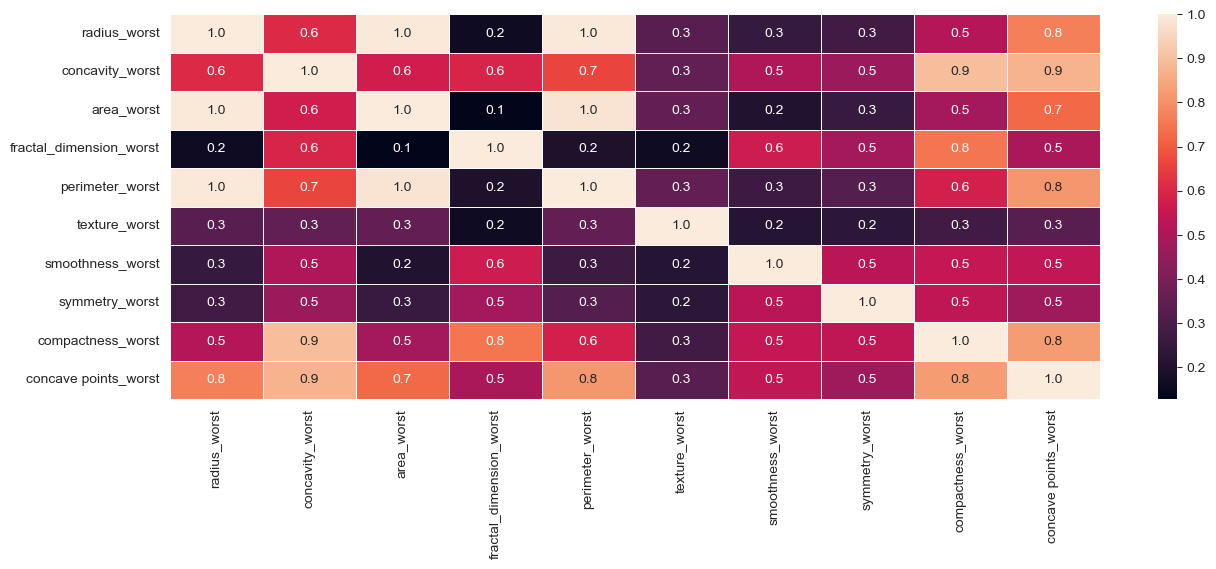

In [357]:
f, ax = plt.subplots(figsize = ( 15, 5))
sns.heatmap(df_worst.drop('diagnosis',axis=1).corr(), annot = True, linewidth = 0.5, fmt = '.1f', ax = ax )
plt.show()

## Once we have identified the most correlated features, we need to keep only uncorrelated features in order to avoid overfitting and autocorrelation issues. We'll repeat this process to each dataset (se,mean,worst) and later we'll repeat the same process over the whole dataset to obtain non highly correlated data.

## 10. Dropping highly correlated features of df_mean dataset :

In [358]:
# Create correlation matrix
corr_matrix = df_mean.drop('diagnosis',axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]
df_mean.drop(df_mean[to_drop], axis=1,inplace=True)


C:\Users\NICON\AppData\Local\Temp\ipykernel_13968\2863052378.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
C:\Users\NICON\AppData\Local\Temp\ipykernel_13968\2863052378.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mean.drop(df_mean[to_drop], axis=1,inplace=True)


**After dropping highly correlated features of df_mean dataset , we get a df_mean dataset with 5 columns out of the initial 10.**

In [359]:
df_mean.columns

Index(['diagnosis', 'concave points_mean', 'smoothness_mean', 'texture_mean',
       'fractal_dimension_mean', 'symmetry_mean'],
      dtype='object')

## 11. Dropping highly correlated features of df_se dataset :


In [360]:
# Create correlation matrix
corr_matrix = df_se.drop('diagnosis',axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]
df_se.drop(df_se[to_drop], axis=1,inplace=True)


C:\Users\NICON\AppData\Local\Temp\ipykernel_13968\4076443033.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
C:\Users\NICON\AppData\Local\Temp\ipykernel_13968\4076443033.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_se.drop(df_se[to_drop], axis=1,inplace=True)


**After dropping highly correlated features of df_mean dataset , we get a df_mean dataset with 6 features out of the initial 10.**


In [361]:
df_se.columns

Index(['diagnosis', 'perimeter_se', 'concavity_se', 'smoothness_se',
       'texture_se', 'fractal_dimension_se', 'symmetry_se'],
      dtype='object')

## 11. Dropping highly correlated features of df_worst dataset :


In [362]:
# Create correlation matrix
corr_matrix = df_worst.drop('diagnosis',axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]
df_worst.drop(df_worst[to_drop], axis=1,inplace=True)

C:\Users\NICON\AppData\Local\Temp\ipykernel_13968\763572103.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
C:\Users\NICON\AppData\Local\Temp\ipykernel_13968\763572103.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_worst.drop(df_worst[to_drop], axis=1,inplace=True)


**After dropping highly correlated features of df_worst dataset , we get a df_mean dataset with 6 features out of the initial 10.**


In [381]:
df_worst.to_parquet("../data/interim/df_worst.parquet", index = False)


In [382]:
df_se.to_parquet("../data/interim/df_se.parquet", index = False)


In [383]:
df_mean.to_parquet("../data/interim/df_mean.parquet", index = False)
